# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The summary of main steps you take in this notebook are as following:

1. Install custom libraries
2. Load the data
1. Understand and process the data through exploratory data analysis and demonstrate the use of Fabric Data Wrangler feature
1. Train machine learning models using Scikit-Learn and LightGBM
1. Evaluate and save the final machine learning model
1. Demonstrate the model performance via visualizations in Power BI


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

## Step 1: Install Custom Libraries

When developing a machine learning model or doing ad-hoc data analysis, you may need to quickly install custom libraries (e.g., `imbalance` and `randomForest` in this notebook) for the Apache Spark session. To do this, you have two choices. 

1. You can use the in-line installation capabilities (e.g., `install.packages`, `devtools::install_version`, etc.) to quickly get started with new libraries. Note that this approach only installs the custom libraries in current notebook and not in the workspace.

```R
# Use R base to install libraries
install.packages(<library name>)

# Use devtools to install libraries
devtools::install_version(<library name>, version = <library version>)
```
<br>

2. Alternatively, you can follow the instructions [here](https://aka.ms/fabric/create-environment) to learn how to create an environment which allows you to install libraries from public sources or upload custom libraries built by you or your organization.

In this notebook, you will be using the `imbalance` and `randomForest` libraries.  To install in the workspace, upload the libraries' dependencies and then the libraries to the workspace. Once successfully uploaded, you can use the the libraries `imbalance` and `randomForest` in the notebook via `library(imbalance)` and `library(randomForest)`, respectively.

In the following, you'll use `install.packages()` to install the these libraries.  Set `quiet` to `TRUE` to make output more concise.

In [1]:
# Install dependencies
devtools::install_version("bnlearn", version = "4.8")
# Install imbalance for SMOTE
devtools::install_version("imbalance", version = "1.0.2.1")
# Install Random Forest algorithm
devtools::install_version("randomForest", version = "4.7-1.1")

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 3, Finished, Available)

Installing package into ‘/nfs4/R/user-lib/application_1712267945726_0001’
(as ‘lib’ is unspecified)
Loading required package: usethis
* installing *source* package ‘bnlearn’ ...
** package ‘bnlearn’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
x86_64-conda-linux-gnu-cc -I"/home/trusted-service-user/cluster-env/synapse_trident_r/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/trusted-service-user/cluster-env/synapse_trident_r/include -I/home/trusted-service-user/cluster-env/synapse_trident_r/include -Wl,-rpath-link,/home/trusted-service-user/cluster-env/synapse_trident_r/lib   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/trusted-service-user/cluster-env/synapse_trident_r/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1705202199365/work=/usr/local/src/conda/r-base-4.2.3 -fdebug-prefix-map=/home/truste

## Step 2: Load the data


#### Dataset

The dataset contains churn status of 10000 customers along with 14 attributes that include credit score, geographical location (Germany, France, Spain), gender (male, female), age, tenure (years of being bank's customer), account balance, estimated salary, number of products that a customer has purchased through the bank, credit card status (whether a customer has a credit card or not), and active member status (whether an active bank's customer or not).

The dataset also includes columns such as row number, customer ID, and customer surname that should have no impact on customer's decision to leave the bank. The event that defines the customer's churn is the closing of the customer's bank account, therefore, the column `exit` in the dataset refers to customer's abandonment. Since you don't have much context about these attributes, you'll proceed without having background information about the dataset. Your aim is to understand how these attributes contribute to the `exit` status.

Out of the 10000 customers, only 2037 customers (around 20%) have left the bank. Therefore, given the class imbalance ratio, it is recommended to generate synthetic data.

- churn.csv

|"CustomerID"|"Surname"|"CreditScore"|"Geography"|"Gender"|"Age"|"Tenure"|"Balance"|"NumOfProducts"|"HasCrCard"|"IsActiveMember"|"EstimatedSalary"|"Exited"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|15634602|Hargrave|619|France|Female|42|2|0.00|1|1|1|101348.88|1|
|15647311|Hill|608|Spain|Female|41|1|83807.86|1|0|1|112542.58|0|



#### Introduction to SMOTE

The problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. Synthetic Minority Oversampling Technique (SMOTE) is the most widely used approach to synthesize new samples for the minority class. You can read more about SMOTE [here](https://cran.r-project.org/web/packages/imbalance/imbalance.pdf) and [here](https://cran.r-project.org/web/packages/imbalance/vignettes/imbalance.pdf).

You will be able to access SMOTE using the `imbalance` library that you installed in Step 1.

#### Download dataset and upload to lakehouse

This code downloads a publicly available version of the dataset and then stores it in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [2]:
library(fs)
library(httr)

remote_url <- "https://sdkstorerta.blob.core.windows.net/churnblob"
file_list <- c("churn.csv")
download_path <- "/lakehouse/default/Files/churn/raw"

if (!dir_exists("/lakehouse/default")) {
  stop("Default lakehouse not found, please add a lakehouse and restart the session.")
}
dir_create(download_path, recurse= TRUE)
for (fname in file_list) {
  if (!file_exists(paste0(download_path, "/", fname))) {
    r <- GET(paste0(remote_url, "/", fname), timeout(30))
    writeBin(content(r, "raw"), paste0(download_path, "/", fname))
  }
}
print("Downloaded demo data files into lakehouse.")

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 4, Finished, Available)

[1] "Downloaded demo data files into lakehouse."

Start recording the time it takes to run this notebook.

In [3]:
# Record the notebook running time
ts <- as.numeric(Sys.time())

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 5, Finished, Available)

#### Read raw data from the lakehouse

Reads raw data from the **Files** section of the lakehouse, adds additional columns for different date parts and the same information will be used to create partitioned delta table.

In [4]:
fname <- "churn.csv"
download_path <- "/lakehouse/default/Files/churn/raw"
rdf <- readr::read_csv(paste0(download_path, "/", fname))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 6, Finished, Available)

Rows: 10000 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Surname, Geography, Gender
dbl (11): RowNumber, CustomerId, CreditScore, Age, Tenure, Balance, NumOfPro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Step 3: Exploratory Data Analysis

#### Display raw data

Perform a preliminary exploration of the raw data using the `head()` or `str()` commands.  

In [5]:
head(rdf)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 7, Finished, Available)

# A tibble: 6 × 14
  RowNumber CustomerId Surname CreditScore Geography Gender   Age Tenure Balance
      <dbl>      <dbl> <chr>         <dbl> <chr>     <chr>  <dbl>  <dbl>   <dbl>
1         1   15634602 Hargra…         619 France    Female    42      2      0 
2         2   15647311 Hill            608 Spain     Female    41      1  83808.
3         3   15619304 Onio            502 France    Female    42      8 159661.
4         4   15701354 Boni            699 France    Female    39      1      0 
5         5   15737888 Mitche…         850 Spain     Female    43      2 125511.
6         6   15574012 Chu             645 Spain     Male      44      8 113756.
# ℹ 5 more variables: NumOfProducts <dbl>, HasCrCard <dbl>,
#   IsActiveMember <dbl>, EstimatedSalary <dbl>, Exited <dbl>

#### Initial data cleansing

You first need to convert the R DataFrame to spark DataFrame, then perform the following operations to cleanse the raw dataset.
- Drop the rows with missing data across all columns
- Drop the duplicate rows across the columns `RowNumber` and `CustomerId`
- Drop the columns `RowNumber`, `CustomerId`, and `Surname`

In [6]:
# Transform R DataFrame to spark DataFrame
df <- as.DataFrame(rdf)

clean_data <- function(df) {
  sdf <- df %>%
    # Drop rows with missing data across all columns
    na.omit() %>%
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    dropDuplicates(c("RowNumber", "CustomerId")) %>%
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    SparkR::select("CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited")
  return(sdf)
}

df_clean <- clean_data(df)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 8, Finished, Available)

You can now explore the spark Dataframe with `display` command, do some basic statistics, and even show chart views.

In [7]:
display(df_clean)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, 45d243f7-a946-437d-8320-55759b73c0e1)

#### Determine categorical, numerical, and target attributes

In [8]:
# Determine the dependent (target) attribute
dependent_variable_name <- "Exited"
print(dependent_variable_name)

# Get the distinct values for each column
exprs = lapply(names(df_clean), function(x) alias(countDistinct(df_clean[[x]]), x))
# Use do.call to splice the aggregation expressions to aggregate function
distinct_value_number <- SparkR::collect(do.call(agg, c(x = df_clean, exprs)))

# Determine the categorical attributes
categorical_variables <- names(df_clean)[sapply(names(df_clean), function(col) col %in% c("0") || distinct_value_number[[col]] <= 5 && !(col %in% c(dependent_variable_name)))]
print(categorical_variables)

# Determine the numerical attributes
numeric_variables <- names(df_clean)[sapply(names(df_clean), function(col) coltypes(SparkR::select(df_clean, col)) == "numeric" && distinct_value_number[[col]] > 5)]
print(numeric_variables)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 10, Finished, Available)

[1] "Exited"
[1] "Geography"      "Gender"         "NumOfProducts"  "HasCrCard"     
[5] "IsActiveMember"
[1] "CreditScore"     "Age"             "Tenure"          "Balance"        
[5] "EstimatedSalary"

Convert the spark DataFrame to R DataFrame for easier processing and visualization.

In [9]:
# Transfrom spark DataFrame to R DataFrame
rdf_clean <- SparkR::collect(df_clean)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 11, Finished, Available)

##### The five-number summary 

Show the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the numerical attributes, using box plots.

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 12, Finished, Available)

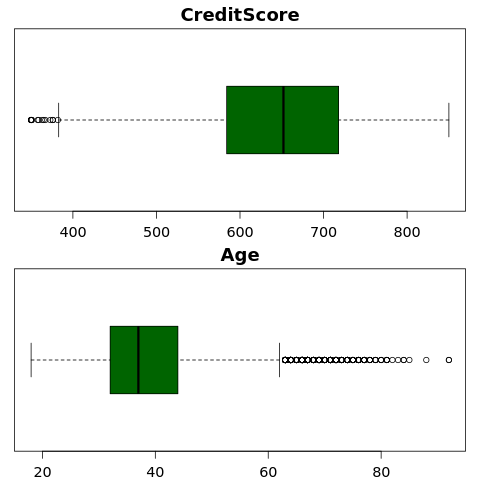

In [10]:
# Set the overall layout of the graphics window
par(mfrow = c(2, 1), 
    mar = c(2, 1, 2, 1)) # margin size

for(item in numeric_variables[1:2]){
    # Create boxplot
    boxplot(rdf_clean[, item], 
            main = item, 
            col = "darkgreen", 
            cex.main = 1.5, # title size
            cex.lab = 1.3, # axis label size
            cex.axis = 1.2,
            horizontal = TRUE) # axis size
}

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 13, Finished, Available)

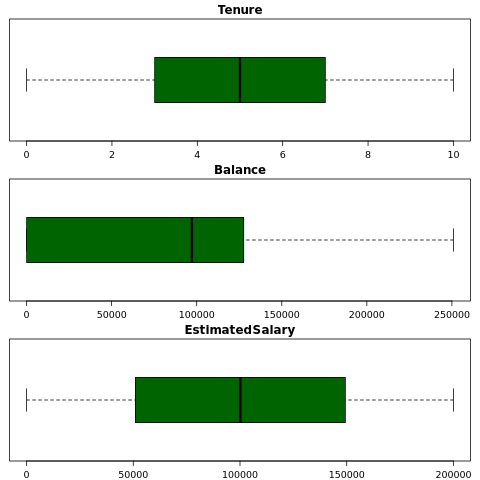

In [11]:
# Set the overall layout of the graphics window
par(mfrow = c(3, 1), 
    mar = c(2, 1, 2, 1)) # margin size

for(item in numeric_variables[3:5]){
    # Create boxplot
    boxplot(rdf_clean[, item], 
            main = item, 
            col = "darkgreen", 
            cex.main = 1.5, # title size
            cex.lab = 1.3, # axis label size
            cex.axis = 1.2,
            horizontal = TRUE) # axis size
}

##### Distribution of exited and non-exited customers 

Show the distribution of exited versus non-exited customers across the categorical attributes.

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 14, Finished, Available)

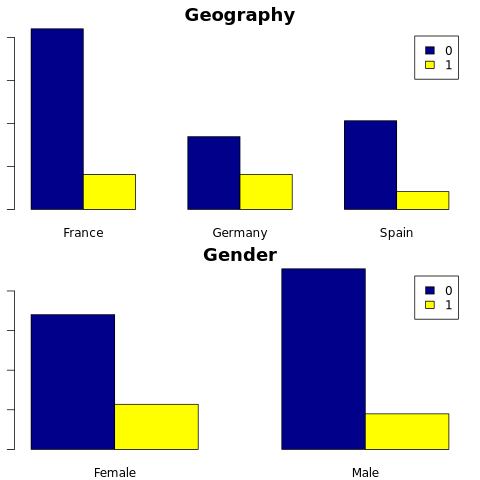

In [12]:
attr_list <- c('Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure')
par(mfrow = c(2, 1), 
    mar = c(2, 1, 2, 1)) # margin size
for (item in attr_list[1:2]) {
    counts <- table(rdf_clean$Exited, rdf_clean[,item])
    barplot(counts, main=item, col=c("darkblue","yellow"), 
            cex.main = 1.5, # title size
            cex.axis = 1.2,
            legend = rownames(counts), beside=TRUE)
}


StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 15, Finished, Available)

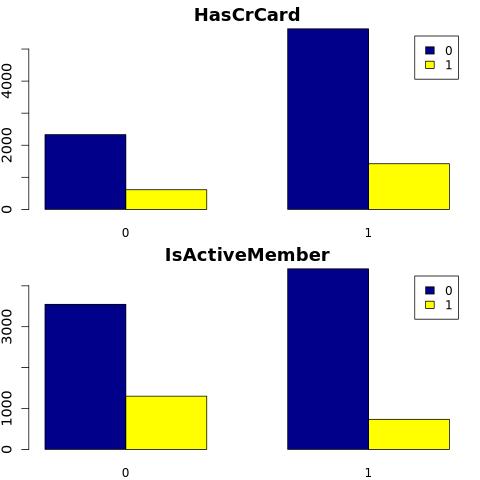

In [13]:
par(mfrow = c(2, 1), 
    mar = c(2, 2, 2, 1)) # margin size
for (item in attr_list[3:4]) {
    counts <- table(rdf_clean$Exited, rdf_clean[,item])
    barplot(counts, main=item, col=c("darkblue","yellow"), 
            cex.main = 1.5, # title size
            cex.axis = 1.2,
            legend = rownames(counts), beside=TRUE)
}

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 16, Finished, Available)

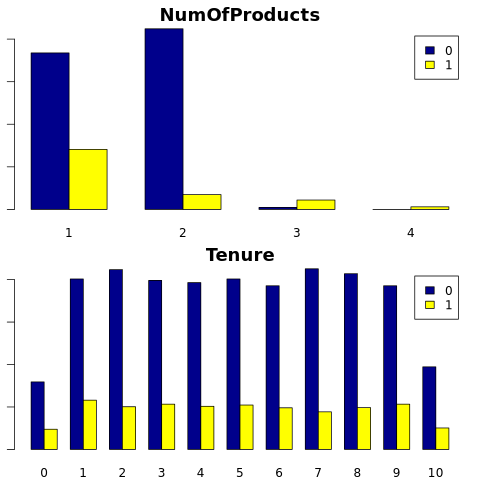

In [14]:
par(mfrow = c(2, 1), 
    mar = c(2, 1, 2, 1)) # margin size
for (item in attr_list[5:6]) {
    counts <- table(rdf_clean$Exited, rdf_clean[,item])
    barplot(counts, main=item, col=c("darkblue","yellow"), 
            cex.main = 1.5, # title size
            cex.axis = 1.2,
            legend = rownames(counts), beside=TRUE)
}

##### Distribution of numerical attributes

Show the the frequency distribution of numerical attributes using histogram.

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 17, Finished, Available)

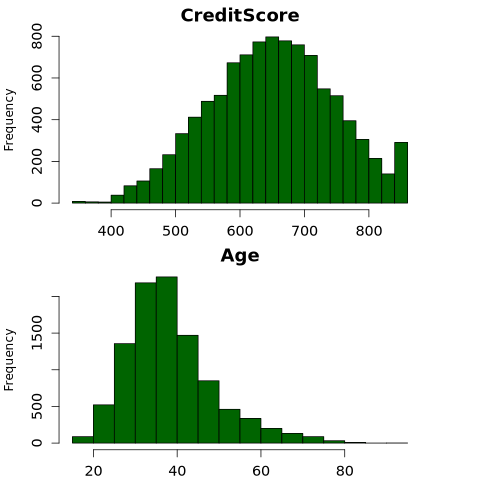

In [15]:
# Set the overall layout of the graphics window
par(mfrow = c(2, 1), 
    mar = c(2, 4, 2, 4) + 0.1) # margin size

# Create histograms
for (item in numeric_variables[1:2]) {
    hist(rdf_clean[, item], 
         main = item, 
         col = "darkgreen", 
         xlab = item,
         cex.main = 1.5, # title size
         cex.axis = 1.2,
         breaks = 20) # number of bins
}

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 18, Finished, Available)

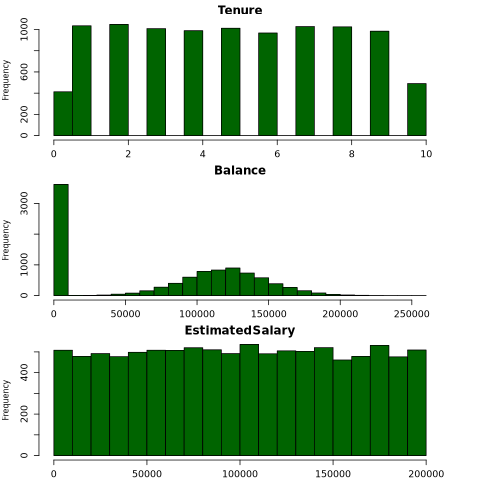

In [16]:
# Set the overall layout of the graphics window
par(mfrow = c(3, 1), 
    mar = c(2, 4, 2, 4) + 0.1) # margin size

# Create histograms
for (item in numeric_variables[3:5]) {
    hist(rdf_clean[, item], 
         main = item, 
         col = "darkgreen", 
         xlab = item,
         cex.main = 1.5, # title size
         cex.axis = 1.2,
         breaks = 20) # number of bins
}

#### Perform feature engineering

The following feature engineering generates new attributes based on current attributes.

In [17]:
rdf_clean$NewTenure <- rdf_clean$Tenure / rdf_clean$Age
rdf_clean$NewCreditsScore <- as.numeric(cut(rdf_clean$CreditScore, breaks=quantile(rdf_clean$CreditScore, probs=seq(0, 1, by=1/6)), include.lowest=TRUE, labels=c(1, 2, 3, 4, 5, 6)))
rdf_clean$NewAgeScore <- as.numeric(cut(rdf_clean$Age, breaks=quantile(rdf_clean$Age, probs=seq(0, 1, by=1/8)), include.lowest=TRUE, labels=c(1, 2, 3, 4, 5, 6, 7, 8)))
rdf_clean$NewBalanceScore <- as.numeric(cut(rank(rdf_clean$Balance), breaks=quantile(rank(rdf_clean$Balance, ties.method = "first"), probs=seq(0, 1, by=1/5)), include.lowest=TRUE, labels=c(1, 2, 3, 4, 5)))
rdf_clean$NewEstSalaryScore <- as.numeric(cut(rdf_clean$EstimatedSalary, breaks=quantile(rdf_clean$EstimatedSalary, probs=seq(0, 1, by=1/10)), include.lowest=TRUE, labels=c(1:10)))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 19, Finished, Available)

#### Perform one-hot encoding

Use one-hot encoding to convert the categorical attributes to the numerical ones so that they can be fed into the machine learning model.

In [18]:
rdf_clean <- cbind(rdf_clean, model.matrix(~Geography+Gender-1, data=rdf_clean))
rdf_clean <- subset(rdf_clean, select = - c(Geography, Gender))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 20, Finished, Available)

#### Create a delta table to generate the Power BI report

In [19]:
table_name <- "rdf_clean"
# Create Spark DataFrame from R data frame
sparkDF <- as.DataFrame(rdf_clean)
write.df(sparkDF, paste0("Tables/", table_name), source = "delta", mode = "overwrite")
cat(paste0("Spark dataframe saved to delta table: ", table_name))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 21, Finished, Available)

Spark dataframe saved to delta table: rdf_clean

#### Summary of observations from the exploratory data analysis

- Most of the customers are from France comparing to Spain and Germany, while Spain has the lowest churn rate comparing to France and Germany.
- Most of the customers have credit cards.
- There are customers whose age and credit score are above 60 and below 400, respectively, but they can't be considered as outliers.
- Very few customers have more than two of the bank's products.
- Customers who are not active have a higher churn rate.
- Gender and tenure years don't seem to have an impact on customer's decision to close the bank account.

## Step 4: Model rraining

With your data in place, you can now define the model. You'll apply Random Forrest and LightGBM models in this notebook. You will leverage `randomForest` and `lightgbm` to implement the models within a few lines of code. 

#### Load the delta table from the lakehouse

You may use other delta tables considering the lakehouse as the source.

In [20]:
SEED <- 12345
rdf_clean <- read.df("Tables/rdf_clean", source = "delta")
df_clean <- as.data.frame(rdf_clean)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 22, Finished, Available)

#### Import randomForest and lightgbm

In [21]:
library(randomForest)
library(lightgbm)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 23, Finished, Available)

randomForest 4.7-1.1
Type rfNews() to see new features/changes/bug fixes.
Loading required package: R6

Attaching package: ‘lightgbm’

The following object is masked from ‘package:SparkR’:

    slice


#### Prepare training and test datasets

In [22]:
set.seed(SEED)
y <- factor(df_clean$Exited)
X <- df_clean[, !(colnames(df_clean) %in% c("Exited"))]
split <- base::sample(c(TRUE, FALSE), nrow(df_clean), replace = TRUE, prob = c(0.8, 0.2))
X_train <- X[split,]
X_test <- X[!split,]
y_train <- y[split]
y_test <- y[!split]
train_df <- cbind(X_train, y_train)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 24, Finished, Available)

#### Apply SMOTE to the training data to synthesize new samples for the minority class

SMOTE should only be applied to the training dataset. You must leave the test dataset in its original imbalanced distribution in order to get a valid approximation of how the model will perform on the original data, which is representing the situation in production.

Start by showing the distribution of classes in the dataset in order to find out which class is the minority class. The ratio of minority class to majority class is defined as `imbalace ratio` in imbalance library.

In [23]:
original_ratio <- imbalance::imbalanceRatio(train_df, classAttr = "y_train")
message(sprintf("Original imbalance ratio is %.2f%% as {Size of minority class}/{Size of majority class}.", original_ratio * 100))
message(sprintf("Positive class(Exited) takes %.2f%% of the dataset.", round(sum(train_df$y_train == 1)/nrow(train_df) * 100, 2)))
message(sprintf("Negatvie class(Non-Exited) takes %.2f%% of the dataset.", round(sum(train_df$y_train == 0)/nrow(train_df) * 100, 2)))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 25, Finished, Available)

Original imbalance ratio is 25.53% as {Size of minority class}/{Size of majority class}.
Positive class(Exited) takes 20.34% of the dataset.
Negatvie class(Non-Exited) takes 79.66% of the dataset.

In the training dataset, the `positive class (Exited)` refers the minority class which takes 20.34% of the dataset and `negative class (Non-Exited)` refers to the majority class that takes 79.66% of the dataset. 

The next cell rewrites the oversample function in `imbalance` library in order to generate a balanced dataset.

In [24]:
binary_oversample <- function(train_df, X_train, y_train, class_Attr = "Class"){
    negative_num <- sum(y_train == 0) # Compute the number of negative class
    positive_num <- sum(y_train == 1) # Compute the number of positive class
    difference_num <- abs(negative_num - positive_num) # Compute the difference between negative and positive class
    originalShape <- imbalance:::datasetStructure(train_df, class_Attr) # Get the original dataset schema
    new_samples <- smotefamily::SMOTE(X_train, y_train, dup_size = ceiling(max(negative_num, positive_num)/min(negative_num, positive_num))) # Use SMOTE to oversample
    new_samples <- new_samples$syn_data # Get the synthetic data
    new_samples <- new_samples[base::sample(1:nrow(new_samples), size = difference_num), ] # Sample and shuffle the synthetic data
    new_samples <- new_samples[, -ncol(new_samples)] # Remove the class colomn
    new_samples <- imbalance:::normalizeNewSamples(originalShape, new_samples) # Normalize the synthetic data
    new_train_df <- rbind(train_df, new_samples) # Concat original and synthetic data by row
    new_train_df <- new_train_df[base::sample(nrow(new_train_df)), ] # shuffle the training dataset
    new_train_df
}

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 26, Finished, Available)

#### Oversample the training dataset 

Use the newly defined oversample function to perform oversampling on the training dataset.

In [25]:
library(dplyr)
new_train_df <- binary_oversample(train_df, X_train, y_train, class_Attr="y_train")
smote_ratio <- imbalance::imbalanceRatio(new_train_df, classAttr = "y_train")
message(sprintf("Imbalance ratio after using smote is %.2f%%\n", smote_ratio * 100))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 27, Finished, Available)


Attaching package: ‘dplyr’

The following object is masked from ‘package:lightgbm’:

    slice

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:SparkR’:

    arrange, between, coalesce, collect, contains, count, cume_dist,
    dense_rank, desc, distinct, explain, expr, filter, first, group_by,
    intersect, lag, last, lead, mutate, n, n_distinct, ntile,
    percent_rank, rename, row_number, sample_frac, select, slice, sql,
    summarize, union, where

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Imbalance ratio after using smote is 100.00%


#### Model Training

Train the model using Random Forest with four features.

In [26]:
set.seed(1)
rfc1_sm <- randomForest(y_train ~ ., data = new_train_df, ntree = 500, mtry = 4, nodesize = 3)
y_pred <- predict(rfc1_sm, X_test, type = "response")
cr_rfc1_sm <- caret::confusionMatrix(y_pred, y_test)
cm_rfc1_sm <- table(y_pred, y_test)
roc_auc_rfc1_sm <- pROC::auc(pROC::roc(as.numeric(y_test), as.numeric(y_pred)))
print(paste0("The auc is ", roc_auc_rfc1_sm))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 28, Finished, Available)

Setting levels: control = 1, case = 2
Setting direction: controls < cases
[1] "The auc is 0.72534355994432"

Train the model using Random Forest with six features.

In [27]:
rfc2_sm <- randomForest(y_train ~ ., data = new_train_df, ntree = 500, mtry = 6, nodesize = 3)
y_pred <- predict(rfc2_sm, X_test, type = "response")
cr_rfc2_sm <- caret::confusionMatrix(y_pred, y_test)
cm_rfc2_sm <- table(y_pred, y_test)
roc_auc_rfc2_sm <- pROC::auc(pROC::roc(as.numeric(y_test), as.numeric(y_pred)))
print(paste0("The auc is ", roc_auc_rfc2_sm))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 29, Finished, Available)

Setting levels: control = 1, case = 2
Setting direction: controls < cases
[1] "The auc is 0.723998281032502"

Train the model using LightGBM.

In [28]:
set.seed(42)
X_train <- new_train_df[, !(colnames(new_train_df) %in% c("y_train"))]
y_train <- as.numeric(as.character(new_train_df$y_train))
y_test <- as.numeric(as.character(y_test))
lgbm_sm_model <- lgb.train(list(objective = "binary", learning_rate = 0.1, max_delta_step = 2, nrounds = 100, max_depth = 10, eval_metric = "logloss"), lgb.Dataset(as.matrix(X_train), label = as.vector(y_train)), valids = list(test = lgb.Dataset(as.matrix(X_test), label = as.vector(as.numeric(y_test)))))
y_pred <- as.numeric(predict(lgbm_sm_model, as.matrix(X_test)) > 0.5)
accuracy <- mean(y_pred == as.vector(y_test))
cr_lgbm_sm <- caret::confusionMatrix(as.factor(y_pred), as.factor(as.vector(y_test)))
cm_lgbm_sm <- table(y_pred, as.vector(y_test))
roc_auc_lgbm_sm <- pROC::auc(pROC::roc(as.vector(y_test), y_pred))
print(paste0("The auc is ", roc_auc_lgbm_sm))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 30, Finished, Available)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6385, number of negative: 6385
[LightGBM] 

## Step 5: Evaluate and save the final machine learning model


#### Assess the performances of the saved models on test dataset

In [29]:
ypred_rfc1_sm <- predict(rfc1_sm, X_test, type = "response")
ypred_rfc2_sm <- predict(rfc2_sm, X_test, type = "response")
ypred_lgbm1_sm <- as.numeric(predict(lgbm_sm_model, as.matrix(X_test)) > 0.5)

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 31, Finished, Available)

 #### Show True/False Positives/Negatives using the Confusion Matrix
 
 Develop a script to plot the confusion matrix in order to evaluate the accuracy of the classification.

In [30]:
plot_confusion_matrix <- function(cm, classes, normalize=FALSE, title='Confusion matrix', cmap=heat.colors(10)) {
  if (normalize) {
    cm <- cm / rowSums(cm)
  }
  op <- par(mar = c(6,6,3,1))
  image(1:nrow(cm), 1:ncol(cm), t(cm[nrow(cm):1,]), col = cmap, xaxt = 'n', yaxt = 'n', main = title, xlab = "Prediction", ylab = "Reference")
  axis(1, at = 1:nrow(cm), labels = classes, las = 2)
  axis(2, at = 1:ncol(cm), labels = rev(classes))
  for (i in seq_len(nrow(cm))) {
    for (j in seq_len(ncol(cm))) {
      text(i, ncol(cm) - j + 1, cm[j,i], cex = 0.8)
    }
  }
  par(op)
}

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 32, Finished, Available)

Create the confusion matrix for Random Forest Classifier with four features.

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 33, Finished, Available)

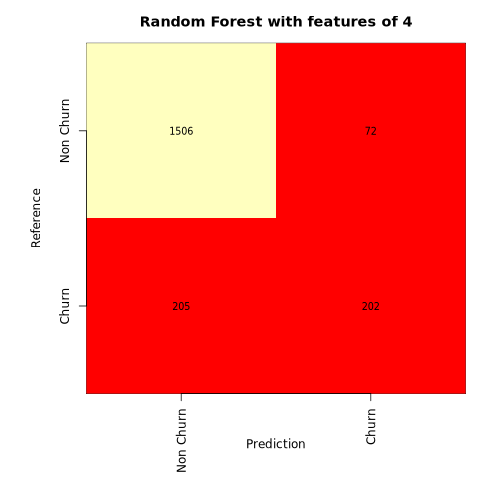

In [31]:
cfm <- table(y_test, ypred_rfc1_sm)
plot_confusion_matrix(cfm, classes=c('Non Churn','Churn'), title='Random Forest with features of 4')
tn <- cfm[1,1]
fp <- cfm[1,2]
fn <- cfm[2,1]
tp <- cfm[2,2]

Create the confusion matrix for Random Forest Classifier with six features.

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 34, Finished, Available)

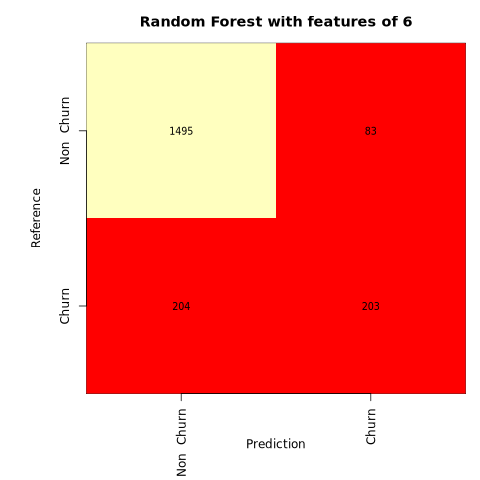

In [32]:
cfm <- table(y_test, ypred_rfc2_sm)
plot_confusion_matrix(cfm, classes=c('Non  Churn','Churn'), title='Random Forest with features of 6')
tn <- cfm[1,1]
fp <- cfm[1,2]
fn <- cfm[2,1]
tp <- cfm[2,2]

Create the confusion matrix for LightGBM.

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 35, Finished, Available)

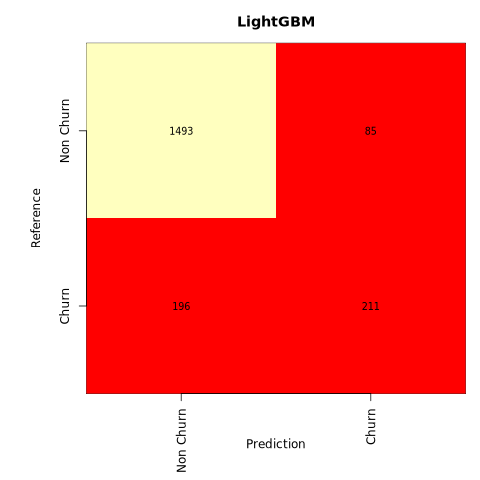

In [33]:
cfm <- table(y_test, ypred_lgbm1_sm)
plot_confusion_matrix(cfm, classes=c('Non Churn','Churn'), title='LightGBM')
tn <- cfm[1,1]
fp <- cfm[1,2]
fn <- cfm[2,1]
tp <- cfm[2,2]

#### Save results for Power BI

Move model prediction results to Power BI Visualization by saving delta frame to lakehouse.

In [34]:
df_pred <- X_test
df_pred$y_test <- y_test
df_pred$ypred_rfc1_sm <- ypred_rfc1_sm
df_pred$ypred_rfc2_sm <- ypred_rfc2_sm
df_pred$ypred_lgbm1_sm <- ypred_lgbm1_sm

table_name <- "df_pred_results"
sparkDF <- as.DataFrame(df_pred)
write.df(sparkDF, paste0("Tables/", table_name), source = "delta", mode = "overwrite", overwriteSchema = "true")

cat(paste0("Spark dataframe saved to delta table: ", table_name))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 36, Finished, Available)

Spark dataframe saved to delta table: df_pred_results

## Step 6: Business Intelligence via Visualizations in Power BI

Use these steps to access your saved table in Power BI.

1. On the left, select **OneLake data hub**.
1. Select the lakehouse that you added to this notebook.
1. On the top right, select **Open** under the section titled **Open this Lakehouse**.
1. Select New Power BI dataset on the top ribbon and select `df_pred_results`, then select **Continue** to create a new Power BI dataset linked to the predictions.
1. On the tools at the top of the dataset page, select **New report** to open the Power BI report authoring page.

Some example visualizations are shown here. The data panel shows the delta tables and columns from the table to select. Upon selecting appropriate x and y axes, you can pick the filters and functions, for example, sum or average of the table column.

> [!NOTE]
> This shows an illustrated example of how you would analyze the saved prediction results in Power BI. However, for a real customer churn use-case, the platform user may have to do more thorough ideation of what visualizations to create, based on subject matter expertise, and what their firm and business analytics team has standardized as metrics.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn/PBIviz3.png"  width="100%" height="100%">

The Power BI report shows that customers who use more than two of the bank products have a higher churn rate although few customers had more than two products. The bank should collect more data, but also investigate other features correlated with more products (see the plot in the bottom left panel).
Bank customers in Germany have a higher churn rate than in France and Spain (see the plot in the bottom right panel), which suggests that an investigation into what has encouraged customers to leave could be beneficial.
There are more middle aged customers (between 25-45) and customers between 45-60 tend to exit more.
Finally, customers with lower credit scores would most likely leave the bank for other financial institutes. The bank should look into ways that encourage customers with lower credit scores and account balances to stay with the bank.

In [35]:
# Determine the entire runtime
cat(paste0("Full run cost ", as.integer(Sys.time() - ts), " seconds.\n"))

StatementMeta(, 8978a8dc-843c-44af-9332-e3e8a0248714, 37, Finished, Available)

Full run cost 305 seconds.